In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon
import numpy as np

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)

In [4]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["PBMC Kang"]

# Loading 6 PBMC datasets and data preparation

In [5]:
adata = sc.read("./data/pbmc_panorama/pbmc_panorama_normalized.h5ad")
# adata = adata[adata.obs["condition"] != "stimulated"]
adata

AnnData object with n_obs × n_vars = 58207 × 5131 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

## Number of cells in each batch & cell type

In [6]:
adata.obs[condition_key].value_counts()

PBMC 10X     26202
PBMC 68K     18006
PBMC Kang    13999
Name: study, dtype: int64

In [7]:
adata.obs[cell_type_key].value_counts()

T            17409
CD4 T        14972
NK            7597
CD14 Mono     6736
CD8 T         4804
B             4750
CD16 Mono     1044
DC             472
Mk             236
pDC            132
Eryth           55
Name: cell_type, dtype: int64

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [9]:
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 58207 × 1000 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Now we leave out one study  (Drop-seq) for training the newtork

In [10]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 44208 × 1000 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [11]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 13999 × 1000 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [12]:
adata_for_training = adata

## Train/Test Split

In [13]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [14]:
train_adata.shape, valid_adata.shape

((46565, 1000), (11642, 1000))

In [15]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [16]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             use_batchnorm=False,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.0005,
                             beta=50.0,
                             eta=10.0,
                             clip_value=1000.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/run/pbmc_panorama/before/",
                             dropout_rate=0.05,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128384      data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [17]:
conditions = adata.obs[condition_key].unique().tolist()

In [18]:
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)

## Training the network

In [19]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder,
              n_epochs=1000,
              batch_size=1024,
              early_stop_limit=50,
              lr_reducer=40,
              n_per_epoch=0,
              save=True,
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 46565 samples, validate on 11642 samples
Epoch 1/1000
 - 3s - loss: 439.4905 - reconstruction_loss: 436.5627 - mmd_loss: 2.9273 - val_loss: 293.8823 - val_reconstruction_loss: 290.9318 - val_mmd_loss: 2.9499
Epoch 2/1000
 - 2s - loss: 273.6116 - reconstruction_loss: 270.3281 - mmd_loss: 3.2830 - val_loss: 245.1123 - val_reconstruction_loss: 241.4290 - val_mmd_loss: 3.6828
Epoch 3/1000
 - 2s - loss: 244.1690 - reconstruction_loss: 241.0261 - mmd_loss: 3.1424 - val_loss: 226.3571 - val_reconstruction_loss: 222.7841 - val_mmd_loss: 3.5726
Epoch 4/1000
 - 2s - loss: 231.5172 - reconstruction_loss: 228.7819 - mmd_loss: 2.7347 - val_loss: 217.9398 - val_reconstruction_loss: 215.0555 - val_mmd_loss: 2.8838
Epoch 5/1000
 - 2s - loss: 223.3893 - reconstruction_loss: 220.9490 - mmd_loss: 2.4398 - val_loss: 210.1517 - val_reconstruction_loss: 207.3903 - val_mmd_loss: 2.7609
Epoch 6/1000
 - 2s - loss: 216.9433 - reconstruction_loss: 214.6484

KeyboardInterrupt: 

In [20]:
network.condition_encoder

{'PBMC 68K': 0, 'PBMC 10X': 1}

In [21]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [22]:
latent_adata = network.to_mmd_layer(train_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 46565 × 32 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [23]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

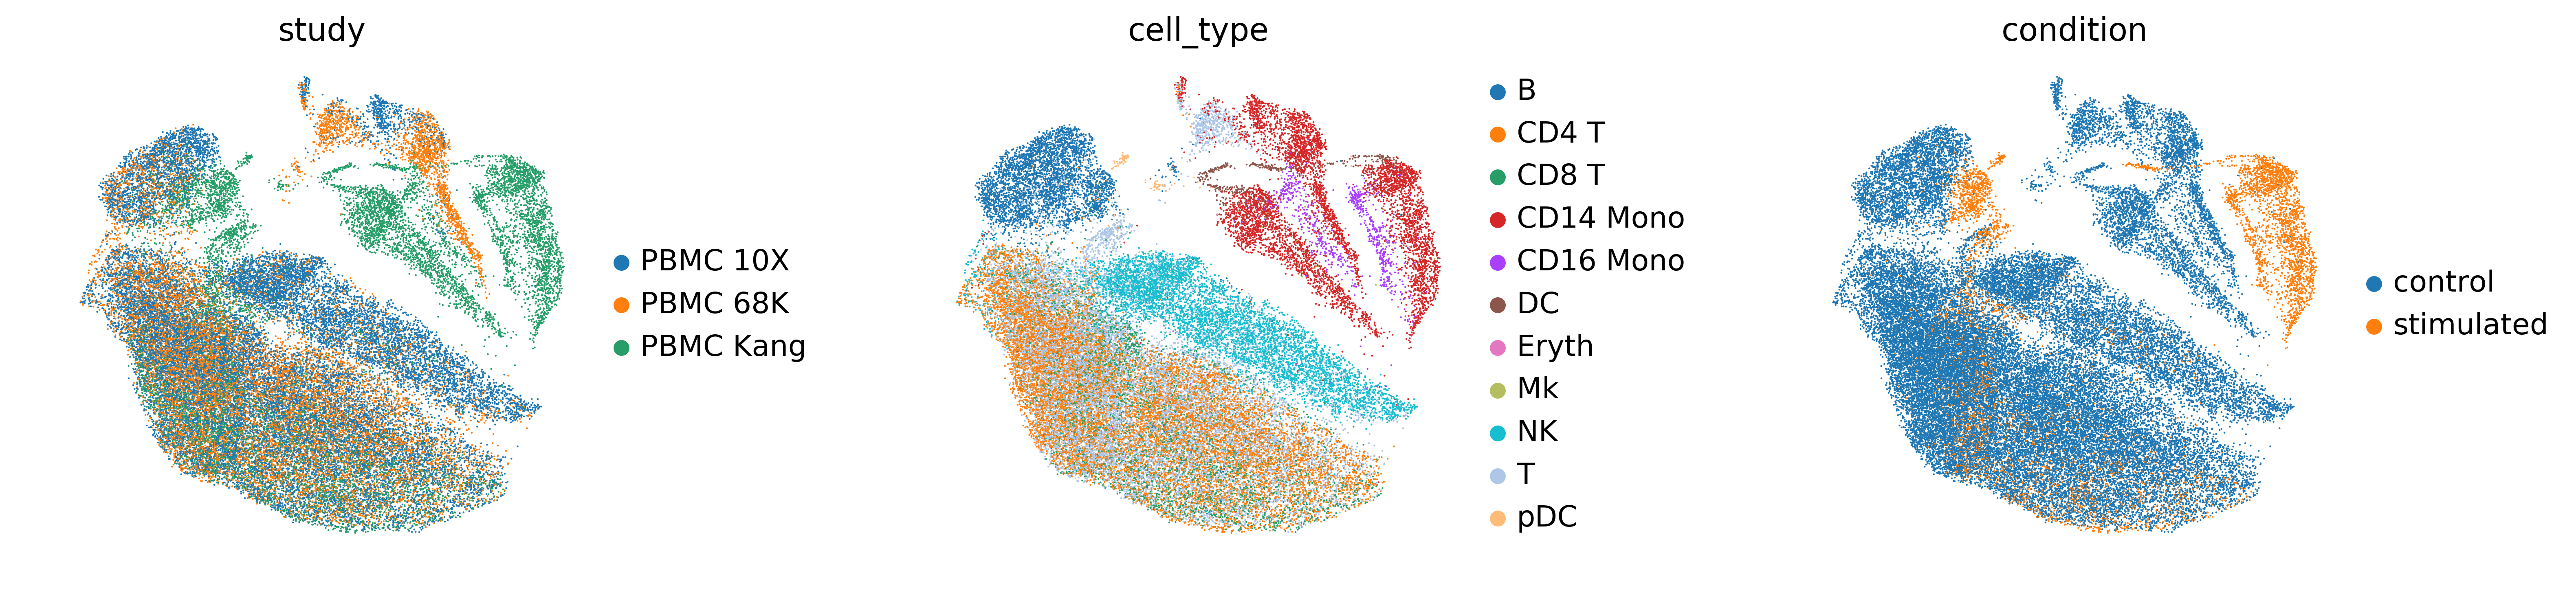

In [25]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key, "condition"], wspace=0.5)

In [26]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.472398384495989

In [27]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.5885687457757306

In [26]:
network.save_model()

# Perfroming architecture Surgery

In [27]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2001)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          256512      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [28]:
network.save_model()

In [29]:
new_network.condition_encoder

{'PBMC 68K': 0, 'PBMC 10X': 1, 'PBMC Kang': 2}

## Train with small new dataset containing out-of-sample condition

In [30]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [31]:
train_adata.shape, valid_adata.shape

((5238, 2001), (1310, 2001))

In [ ]:
new_network.train(train_adata,
                  valid_adata,
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder,
                  n_epochs=10000,
                  batch_size=1024,
                  n_epochs_warmup=0,
                  early_stop_limit=100,
                  lr_reducer=80,
                  n_per_epoch=0,
                  save=False,
                  retrain=True,
                  verbose=2)

In [33]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [34]:
adata_out_of_sample.obs[condition_key].value_counts()

PBMC Kang    6548
Name: study, dtype: int64

In [35]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 6548 × 32 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [36]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

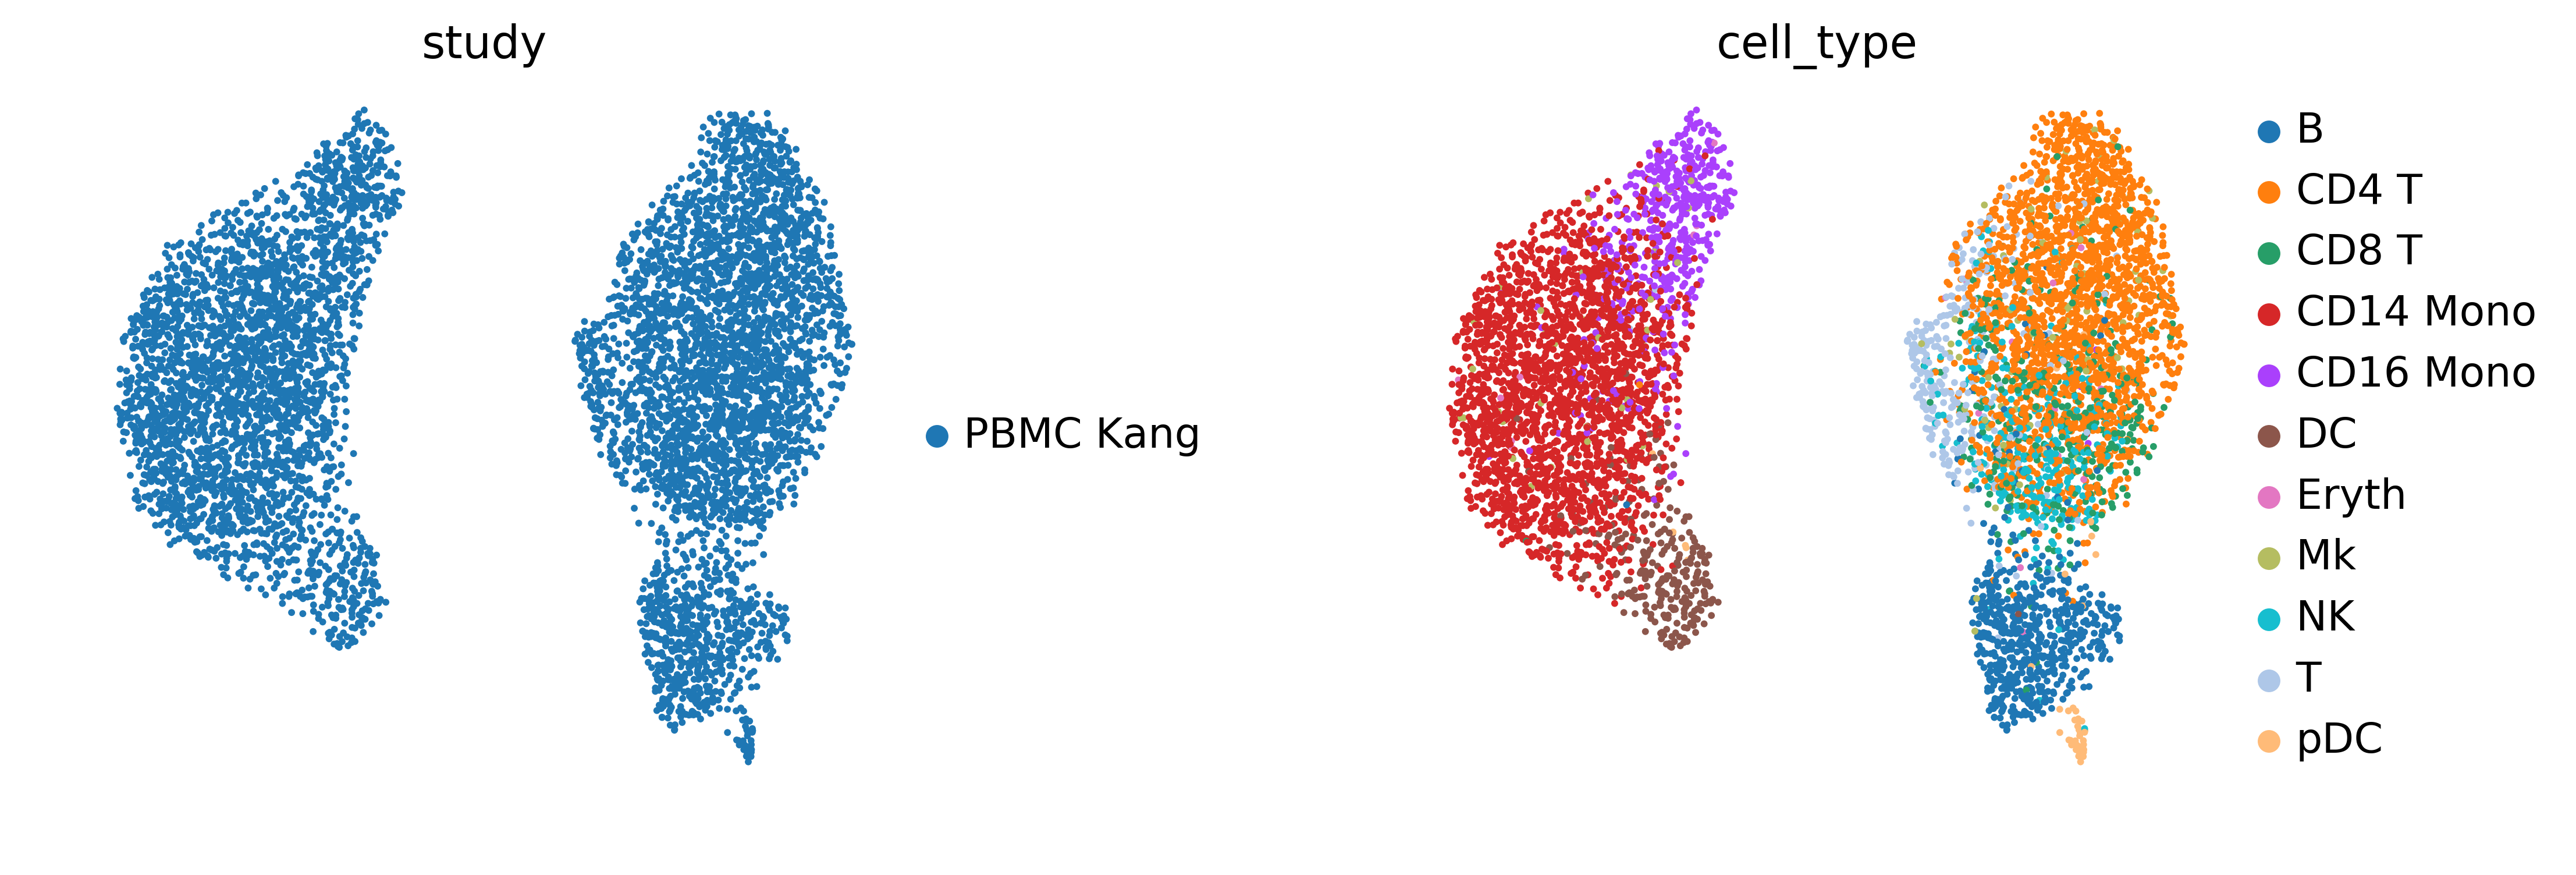

In [37]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [38]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.0

In [39]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.5421281472826799

In [46]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [52]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 50756 × 10 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [53]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

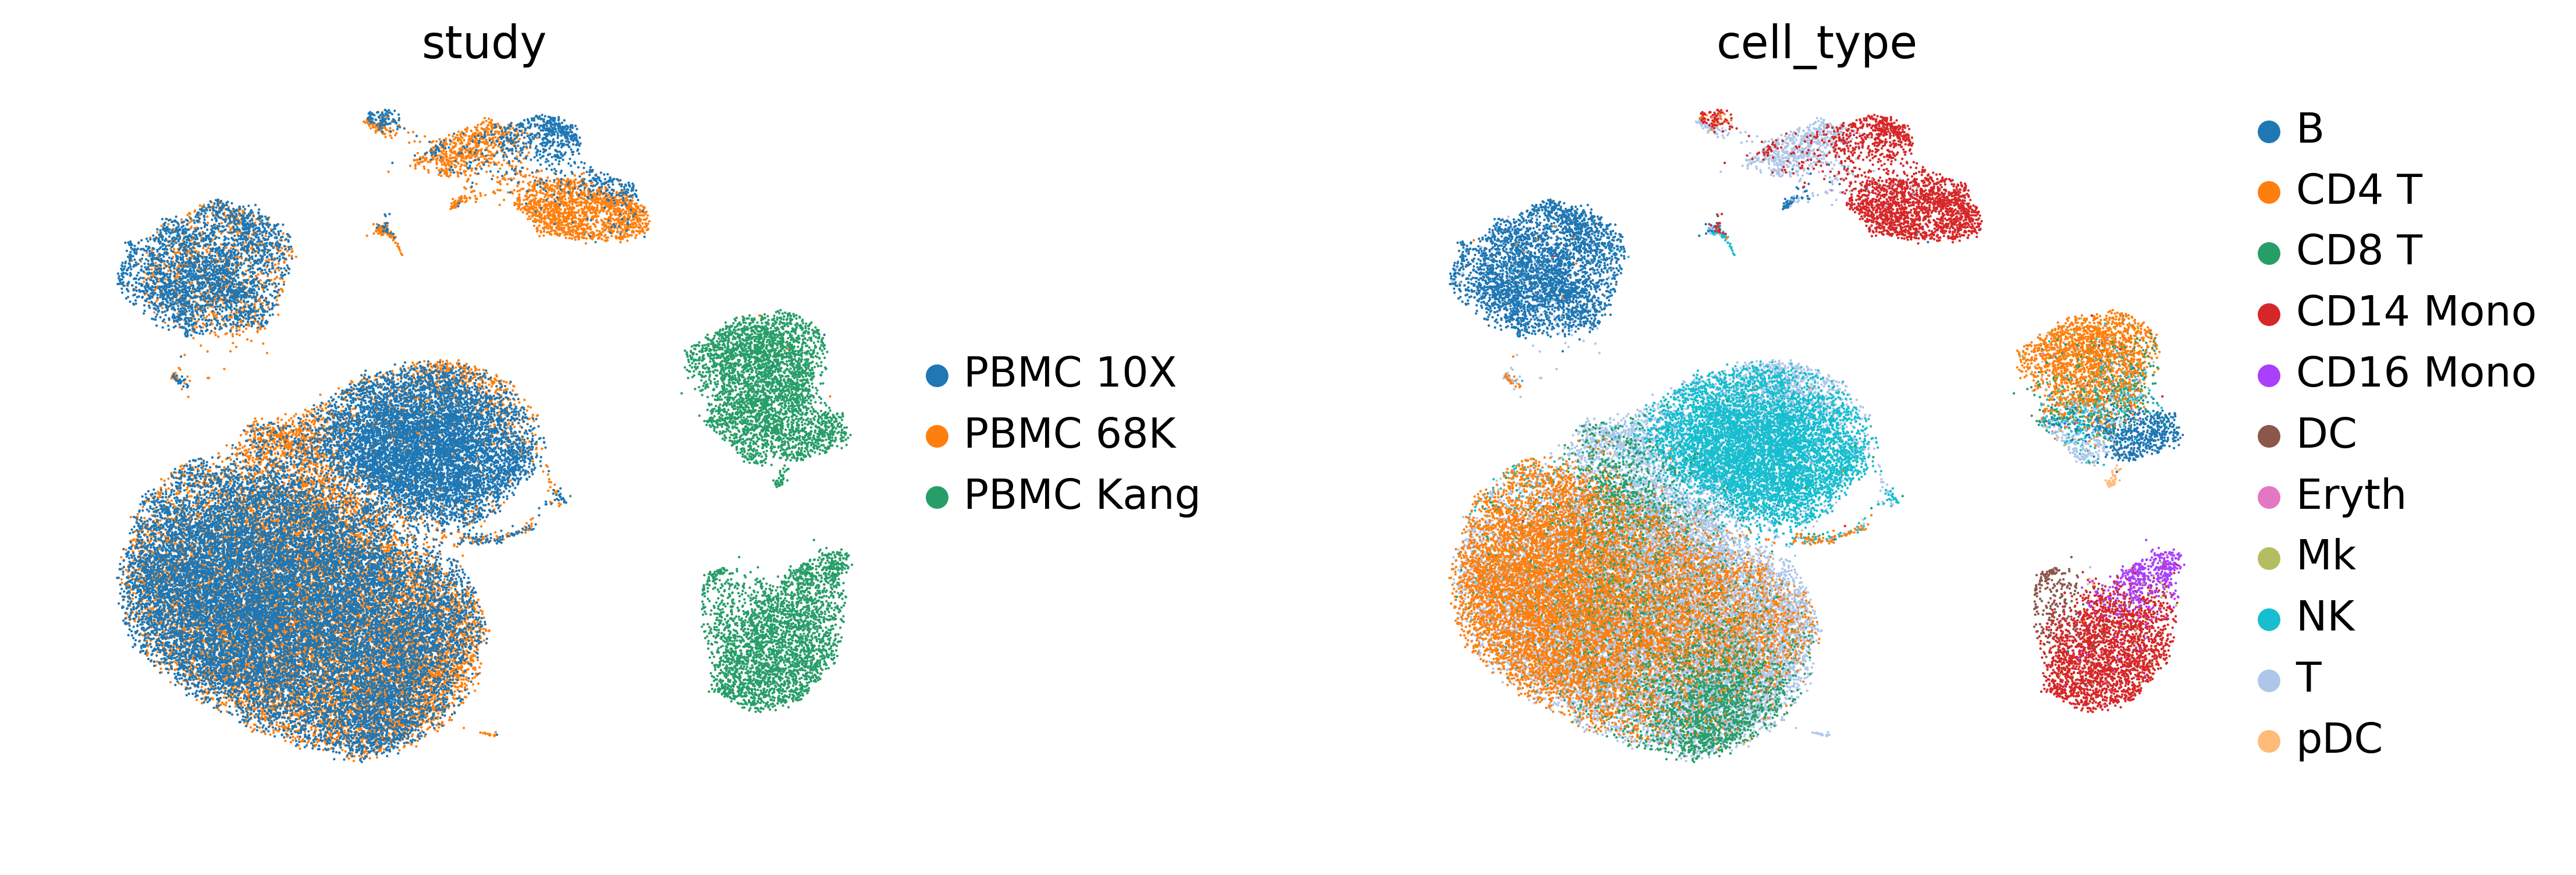

In [54]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [55]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.4242916978611875

In [56]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.5882503763036357